In [65]:
import os
os.environ['THEANO_FLAGS'] = 'device=cpu'
import pandas as pd 
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.metrics import confusion_matrix

In [53]:
data = pd.read_csv('data.csv')
data["Actual_Force"] = data["As"].diff(1) / 0.004
data["Film_Force"] = data["pAs"].diff(1) / 0.004
data.fillna(0, inplace=True)
conditions = [(data['Tot_RUL'] <= 100000),
    (data['Tot_RUL'] >= 100000)]
choices = [0.0, 1.0]
data["label"] = np.select(conditions, choices, default=0)
data

,timestamp,MT,Lag_error,AP,As,pAp,pAs,ple,vax,mode,sample,cycle,RUL,tot_cycle,Tot_RUL,Actual_Force,Film_Force,label
0,0.008000,0.670726,-0.050846,939333465,-6674.194336,409999463,12294.263672,1.043955,2699.999512,0,0.0,1,2047,1,204799,0.000000,0.000000,1.0
1,0.012000,0.456506,0.003138,939333438,-6794.356934,409999513,12269.095703,1.066463,2699.999512,0,0.0,2,2046,2,204798,-30040.649415,-6291.992188,1.0
2,0.016000,0.520841,0.005510,939333411,-6749.725098,409999562,12261.545898,1.120736,2699.999512,0,0.0,3,2045,3,204797,11157.958985,-1887.451172,1.0
3,0.020000,0.568736,-0.028143,939333384,-6780.624023,409999611,12286.712891,1.180041,2699.999512,0,0.0,4,2044,4,204796,-7724.731445,6291.748047,1.0
4,0.024000,0.576378,-0.028126,939333357,-6763.458008,409999661,12281.679688,1.163287,2699.999512,0,0.0,5,2043,5,204795,4291.503905,-1258.300780,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1062907,8.179999,0.369686,-1.367144,5530159,9352.111328,18877402,5212.163574,0.567995,1799.999756,4,493.0,2044,4,204796,4,-15449.462890,-27684.082033,0.0
1062908,8.183999,-0.330580,-0.919746,5530195,9094.619141,18877422,5144.211914,0.417207,1799.999756,4,493.0,2045,3,204797,3,-64373.046875,-16987.915037,0.0
1062909,8.187999,0.063502,-0.746151,5530231,9005.355469,18877443,5106.460449,0.341877,1799.999756,4,493.0,2046,2,204798,2,-22315.917967,-9437.866213,0.0
1062910,8.191999,-0.211253,-0.460982,5530267,8912.658203,18877463,5141.695312,0.400728,1799.999756,4,493.0,2047,1,204799,1,-23174.316408,8808.715823,0.0


In [54]:
df_2 = data.drop(['mode','cycle','RUL','tot_cycle','Tot_RUL'], axis = 1, inplace = True)
df_2 = data.groupby('sample')['timestamp','MT','Lag_error','AP','As','pAp','pAs','ple','vax','Actual_Force','Film_Force','label'].mean()

In [55]:
for i in df_2:
    df_1 = (df_2 - df_2.mean())/df_2.std()
df_1

,timestamp,MT,Lag_error,AP,As,pAp,pAs,ple,vax,Actual_Force,Film_Force,label
sample,,,,,,,,,,,,
0.0,-0.096259,0.064201,-0.314073,0.817811,-0.084752,0.217319,0.233169,-0.445066,0.142799,-0.818108,-0.270620,1.017940
1.0,-0.096259,-0.615727,-0.535019,0.533884,-0.615663,-0.527701,-1.016273,-1.424775,-1.113851,0.789437,-0.708202,1.017940
2.0,-0.096259,2.168866,0.114159,0.534362,-1.932119,-0.525319,-1.119113,-1.576431,-1.042446,-0.270805,-0.501820,-0.985886
3.0,-0.096259,0.106234,0.427801,0.534682,-0.949150,-0.523724,-0.897362,-1.190405,-0.838126,0.081430,0.531134,1.017940
4.0,-0.096259,0.312869,0.285377,0.534969,-0.858481,-0.522296,-0.847728,-1.211941,-0.838126,-0.577052,0.019621,-0.985886
...,...,...,...,...,...,...,...,...,...,...,...,...
514.0,-0.096259,0.378970,2.862514,-0.548537,-0.529406,-0.210797,-0.822322,-0.895183,-0.654309,-0.545720,0.109488,-0.985886
515.0,-0.096259,-2.083061,-0.055128,-0.279936,-0.205421,0.238824,-0.113802,-0.325951,-0.194768,-0.841860,-0.175789,-0.985886
516.0,-0.096259,-2.063641,2.422514,-0.274779,-0.182826,0.268293,-0.127435,-0.591613,-0.194768,-0.885321,-0.033150,-0.985886


In [86]:
predictors = ['Lag_error','AP','As','pAp','pAs','ple','vax','Actual_Force','Film_Force']

The likelihood of the data given regression coefficients β and covariates Xi is Yi ∼ N(βTXi,σ2)
• β∼N(0,10)
• σ2 ∼ InverseGamma(0.1, 0.1)

In [7]:
y = np.array(df_1['label'])
x = df_1.drop('label', axis=1).values
x_train, x_test, y_train, y_test = train_test_split(x[:518], y)
# Target distribution (count values)
print("Label distribution - 0 worn; 1 unworn:")
print(data['label'].value_counts())
y_test.size

Label distribution - 0 worn; 1 unworn:
0.0    538917
1.0    523995
Name: label, dtype: int64


130

In [16]:
from theano import tensor as tt
from matplotlib import pyplot as plt
with pm.Model() as model:
        intercept = pm.Normal('intercept')
        beta     = pm.Normal('beta',shape=len(predictors))
        variance  = pm.InverseGamma('variance',alpha=0.1,beta=0.1)
        sd        = pm.Deterministic('sd',variance**0.5)
        yhat = pm.Deterministic('yhat',intercept + pm.math.dot(df_1[predictors],beta))
        y    = pm.Normal('y',mu=yhat,sd=sd, observed=df_1['MT'])
        trace_1 = pm.sample()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [variance, beta, intercept]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:05<00:00, 336.00draws/s]
The acceptance probability does not match the target. It is 0.8939684919417327, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.886335038255376, but should be close to 0.8. Try to increase the number of tuning steps.


In [18]:
R2_1 = pm.stats.r2_score(df_1['MT'].values.reshape(1,518),trace['yhat'])
WAIC_1 = pm.stats.waic(trace,model = model)
print(R2_1order)
print(WAIC_1order)
WAIC_1.WAIC

r2_r(r2_median=0.78, r2_mean=0.78, r2_std=0.01)
WAIC_r(WAIC=742.6212415442267, WAIC_se=47.39950354200081, p_WAIC=47.62636623465855, var_warn=1)


824.9130585744908

In [12]:
index = list(range(45))
n =0
new_df = pd.DataFrame()
for i in range (len(predictors)):
    for j in range(i,len(predictors)):
        index[n] = predictors[i] + predictors[j]
        new_df[index[n]]= df_1[predictors[i]].mul(df_1[predictors[j]])
        n +=1
new_df = (new_df - new_df.mean())/new_df.std()
result = pd.concat([df_1, new_df], axis=1, sort=False)

with pm.Model() as Deterministic_model:
    intercept = pm.Normal('intercept')
    beta1 = pm.Normal('beta1',shape=len(predictors))
    beta2 = pm.Normal('beta2',shape=45)
    variance = pm.InverseGamma('variance', alpha = 0.1 ,beta = 0.1)
    sd = pm.Deterministic('sd',variance**0.5)
    yhat = intercept + pm.math.dot(df_1[predictors],beta1) + pm.math.dot(new_df[index],beta2)
    yhat1 = pm.Deterministic('yhat1', yhat)
    y    = pm.Normal('y',mu=yhat,sd=sd, observed= df_1['MT'])
    trace = pm.sample()
    ppc = pm.sample_ppc(trace)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [variance, beta2, beta1, intercept]
100%|██████████| 500/500 [00:00<00:00, 918.15it/s]


In [14]:
R2_ = pm.stats.r2_score(df_1['MT'].values.reshape(1,518),trace['yhat1'])
WAIC_ = pm.stats.waic(trace,model = Deterministic_model)
print(R2_)
print(WAIC_)

r2_r(r2_median=0.78, r2_mean=0.78, r2_std=0.01)
WAIC_r(WAIC=742.6212415442267, WAIC_se=47.39950354200081, p_WAIC=47.62636623465855, var_warn=1)


100%|██████████| 500/500 [00:00<00:00, 1117.54it/s]


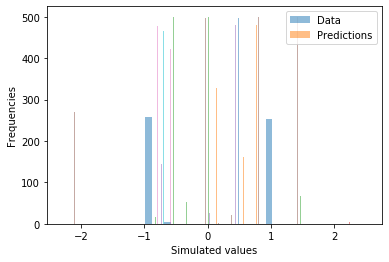

In [99]:
## Posterior Predictive Checks
# Obtain posterior samples
pp = pm.sample_ppc(model=Deterministic_model, trace=trace)
# Plot original data
plt.hist(y, bins=20, alpha=0.5)
# Plot posterior predictives on top of that
plt.hist(pp['y'], bins=20, alpha=0.5)
# Add legend and axes labels
plt.legend(['Data','Predictions'])
plt.xlabel('Simulated values')
plt.ylabel('Frequencies')
plt.show()

In [98]:
predictors = ['Lag_error','AP','As','pAp','pAs','ple','vax','Actual_Force','Film_Force']

100%|██████████| 500/500 [00:00<00:00, 1145.26it/s]


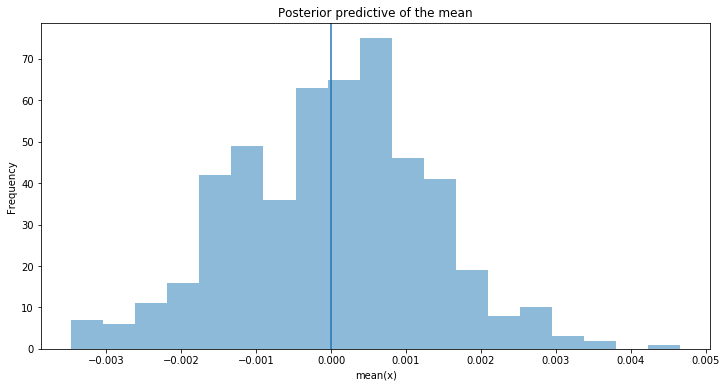

In [91]:
pp = pm.sample_ppc(model=Deterministic_model, trace=trace)
_, ax = plt.subplots(figsize=(12, 6))
ax.hist([y.mean() for y in pp['y']], bins=19, alpha=0.5)
ax.axvline(df_1['MT'].mean())
ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency');

100%|██████████| 500/500 [00:00<00:00, 954.25it/s]


Text(0.5, 1.0, 'Posterior predictive on the test set')

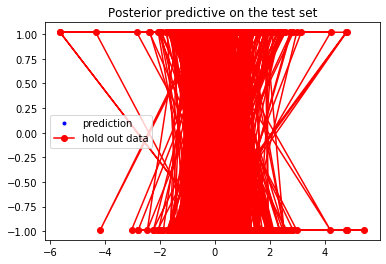

In [60]:
    ppc = pm.sample_ppc(model=Deterministic_model, trace=trace)
    plt.figure()
    plt.plot(x_test, ppc['y'].T, '.b', alpha=0.01)
    plt.plot(x_test, y_test, '-or')
    proxy_arts = [plt.Line2D([0], [0], marker='.', linestyle='', color='b'),
                  plt.Line2D([0], [0], marker='o', linestyle='-', color='r')]
    plt.legend(handles=proxy_arts, labels=['prediction', 'hold out data'])
    plt.title('Posterior predictive on the test set')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vax, ple, pAs, pAp, As, AP, Lag_error, Intercept]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:13<00:00, 301.74draws/s]
There were 957 divergences after tuning. Increase `target_accept` or reparameterize.
There were 905 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


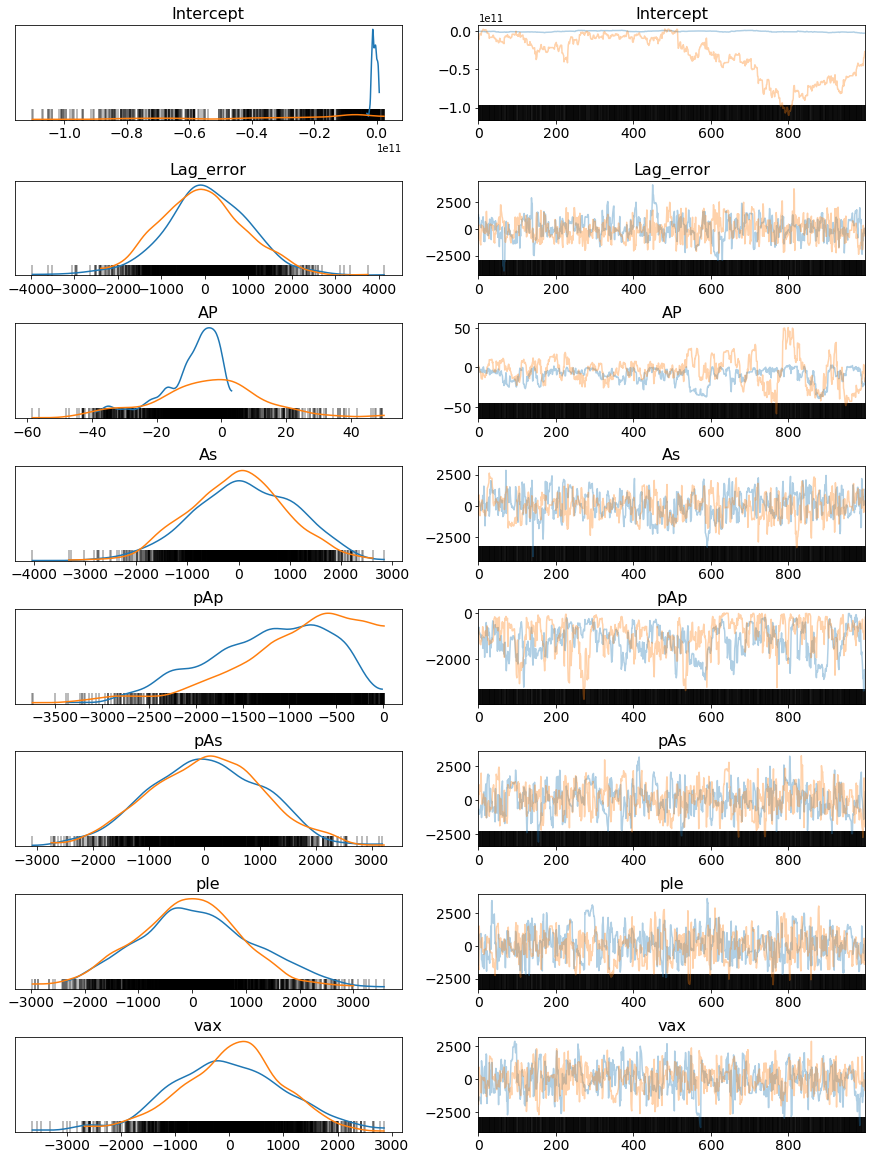

In [56]:
logistic_model = pm.Model()
with logistic_model:
        Create the glm using the Patsy model syntax
        #We use a Binomial distribution for the likelihood
        pm.glm.GLM.from_formula("MT ~ Lag_error + AP + As + pAp + pAs + ple + vax ", df_2, family = pm.glm.families.Binomial())
        trace_logic = pm.sample(1000, tune = 1000, init = 'adapt_diag')

az.plot_trace(trace_logic);        




In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
from collections import OrderedDict

In [39]:
def run_models(df, upper_order=5):
    '''
    Convenience function:
    Fit a range of pymc3 models of increasing polynomial complexity.
    Suggest limit to max order 5 since calculation time is exponential.
    '''

    models, traces = OrderedDict(), OrderedDict()

    for k in range(1,upper_order+1):

        nm = 'k{}'.format(k)
        fml = create_poly_modelspec(k)

        with pm.Model() as models[nm]:

            print('\nRunning: {}'.format(nm))
            pm.glm.GLM.from_formula(fml, df,
                                    family=pm.glm.families.Binomial())

            traces[nm] = pm.sample(1000, tune=1000, init='adapt_diag')

    return models, traces

def create_poly_modelspec(k=1):
    '''
    Convenience function:
    Create a polynomial modelspec string for patsy
    '''
    return ("MT ~ Lag_error + AP + As + pAp + pAs + ple + vax ").strip()


In [57]:
models_lin, traces_lin = run_models(df_2, 5)


Running: k1


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, vax, ple, pAs, pAp, As, AP, Lag_error, Intercept]
Sampling 2 chains: 100%|██████████| 4000/4000 [01:04<00:00, 62.24draws/s]



Running: k2


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, vax, ple, pAs, pAp, As, AP, Lag_error, Intercept]
Sampling 2 chains: 100%|██████████| 4000/4000 [01:06<00:00, 60.57draws/s] 



Running: k3


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, vax, ple, pAs, pAp, As, AP, Lag_error, Intercept]
Sampling 2 chains: 100%|██████████| 4000/4000 [01:00<00:00, 66.39draws/s] 



Running: k4


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, vax, ple, pAs, pAp, As, AP, Lag_error, Intercept]
Sampling 2 chains: 100%|██████████| 4000/4000 [01:00<00:00, 66.60draws/s] 



Running: k5


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, vax, ple, pAs, pAp, As, AP, Lag_error, Intercept]
Sampling 2 chains: 100%|██████████| 4000/4000 [01:01<00:00, 65.49draws/s] 
The acceptance probability does not match the target. It is 0.88249965202818, but should be close to 0.8. Try to increase the number of tuning steps.


In [61]:
model_trace_dict = dict()
for nm in ['k1', 'k2', 'k3', 'k4', 'k5']:
    models_lin[nm].name = nm
    model_trace_dict.update({models_lin[nm]: traces_lin[nm]})
dfwaic = pm.compare(model_trace_dict, ic='WAIC')
dfwaic

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
k2,-2370.75,8.3,0,1,38.12,0,0
k4,-2370.68,8.3,0.07,0,38.04,0.28,0
k5,-2370.37,8.49,0.38,0,38.16,0.25,0
k3,-2370.34,8.54,0.41,0,38.14,0.19,0
k1,-2370.27,8.53,0.48,0,38.09,0.25,0


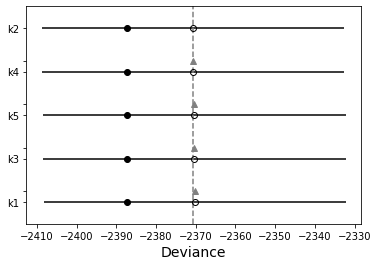

In [59]:
pm.compareplot(dfwaic);

In [107]:
import patsy
Y, X = patsy.dmatrices('MT ~ Lag_error + AP + As + pAp + pAs + ple + vax ', df_2)
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size=0.1,
                                                    train_size=0.1,
                                                    random_state=2000)

In [100]:
from sklearn.linear_model import LinearRegression
my_model = LinearRegression()
my_model.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [101]:
my_model.score(X_test, Y_test)

0.540892791204506

In [111]:
my_predictions = my_model.predict(X_test)
my_predictions

array([[ 1.08099355e+05],
       [-4.05811917e+06],
       [-1.34942352e+07],
       [-8.45471908e+05],
       [-1.66514495e+06],
       [-1.78455163e+06],
       [ 1.28555786e+06],
       [ 3.31033814e+06],
       [-3.77592962e+06],
       [ 4.20937086e+07],
       [ 1.48943719e+05],
       [ 4.77071909e+07],
       [-1.55709953e+07],
       [-1.53921552e+05],
       [-4.36522546e+06],
       [-1.18949492e+06],
       [ 7.17632819e+05],
       [ 6.55152200e+05],
       [-2.73641422e+07],
       [ 4.98978291e+06],
       [-1.97701420e+06],
       [-3.65926435e+07],
       [ 1.52267872e+06],
       [ 1.04617965e+06],
       [ 4.80230225e+05],
       [-4.77880614e+05],
       [-3.69234386e+07],
       [ 6.65448488e+06],
       [-1.19910281e+07],
       [-1.04253385e+07],
       [-1.41043627e+07],
       [ 8.38759618e+05],
       [ 1.42522820e+06],
       [ 9.70010431e+06],
       [ 1.93921489e+06],
       [-5.21637754e+06],
       [-4.78259137e+06],
       [-2.74544407e+07],
       [ 5.7